# Stock Prices Prediction using Adaptive Filters

## Import required libraries

In [ ]:
pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.1
arviz                            0.15.1
astropy                          5.3.2
astunparse                       1.6.3
async-timeout                    4.0.3
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0
blinker                          1.4
bl

In [ ]:
pip install nasdaq-data-link

In [ ]:
pip install padasip

  Preparing metadata (setup.py) ... done
  Created wheel for padasip: filename=padasip-1.2.2-py3-none-any.whl size=51650 sha256=acce4ac9d3db856d47d0a172a812f10d2f77168838c3a91bc6d069815e0d7cc3
  Stored in directory: /root/.cache/pip/wheels/a0/bb/e7/b57f417dbad7d85dbcb177f2c185543ca34a1b36541f115e95
Successfully built padasip


In [ ]:
#%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import padasip as pa
#import quandl
import math
import pickle as pk
from matplotlib import style
import nasdaqdatalink
style.use('ggplot')

## Import the dataset

Here we have imported the dataset from quandl using the quandl API. The dataset consists of McDonalds End of Day prices from 28-06-2016 to 28-12-2018

In [ ]:
nasdaqdatalink.ApiConfig.api_key = "pdp1VhpXmppUs9V2PWE8"
df = nasdaqdatalink.get("BSE/BOM500470",trim_start='2016-06-28', trim_end='2018-12-28', collapse='daily')
df

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
Date,,,,,,,,,,,,
2016-06-28,311.40,314.15,307.35,311.45,311.15,851074.0,11659.0,264813122.0,76352.0,8.97,6.80,0.05
2016-06-29,312.20,316.95,312.20,313.45,314.83,642267.0,9560.0,202206763.0,82959.0,12.92,4.75,1.25
2016-06-30,315.25,324.65,315.25,321.90,319.45,774897.0,11624.0,247544715.0,178016.0,22.97,9.40,6.65
2016-07-01,325.05,330.55,325.05,327.35,328.45,554155.0,8647.0,182009661.0,105205.0,18.98,5.50,2.30
2016-07-04,330.00,333.75,329.00,331.20,331.40,401000.0,5460.0,132893113.0,71966.0,17.95,4.75,1.20
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,523.80,532.00,518.40,520.10,524.46,505317.0,5687.0,265019398.0,69177.0,13.69,13.60,-3.70
2018-12-24,519.90,520.70,512.20,514.40,516.67,610910.0,4677.0,315640200.0,276553.0,45.27,8.50,-5.50
2018-12-26,509.80,517.90,505.15,513.65,509.88,466618.0,5179.0,237917915.0,106404.0,22.80,12.75,3.85


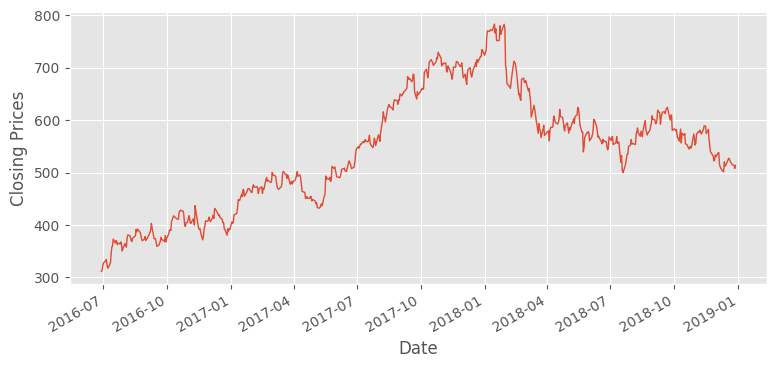

In [ ]:
plt.figure(figsize=(9,4))
plt.ylabel('Closing Prices')
df['Close'].plot(linewidth=1)
plt.show()

In [ ]:
df.shape

(620, 12)

## Data Preprocessing

Here df.info() helps to find out the data type of all the features and also if there are any NaN values in our dataset. As we can see we don't have any NaN values so we don't need to fill them.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 620 entries, 2016-06-28 to 2018-12-28
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Open                       620 non-null    float64
 1   High                       620 non-null    float64
 2   Low                        620 non-null    float64
 3   Close                      620 non-null    float64
 4   WAP                        620 non-null    float64
 5   No. of Shares              620 non-null    float64
 6   No. of Trades              620 non-null    float64
 7   Total Turnover             620 non-null    float64
 8   Deliverable Quantity       620 non-null    float64
 9   % Deli. Qty to Traded Qty  620 non-null    float64
 10  Spread H-L                 620 non-null    float64
 11  Spread C-O                 620 non-null    float64
dtypes: float64(12)
memory usage: 63.0 KB


Here we drop features that are not necessary for our prediction.

In [ ]:
df.drop(['Open', 'High', 'Low', 'WAP','No. of Shares','No. of Trades','Total Turnover','Deliverable Quantity','% Deli. Qty to Traded Qty','Spread H-L','Spread C-O'], axis=1, inplace=True)

In [ ]:
df['Close']

Date
2016-06-28    311.45
2016-06-29    313.45
2016-06-30    321.90
2016-07-01    327.35
2016-07-04    331.20
               ...  
2018-12-21    520.10
2018-12-24    514.40
2018-12-26    513.65
2018-12-27    507.80
2018-12-28    513.70
Name: Close, Length: 620, dtype: float64

## Preparation of source input and train test split

Here we are generating the source input array, which will be useful in generating the 2D matrix 'x' which will be our input. We will be taking first 360 values as our source input

In [ ]:
arr=np.array(df['Close'])
# Specify the percentage of data to use for training (e.g., 80%)
train_percentage = 0.8
# Calculate the index to split the data
split_index = int(len(arr) * train_percentage)
s=arr[:split_index]
s = df['Close'].values.flatten()[:split_index]
n=5


## Preparation of Input matrix

We will use the 'input_from_history' function from the Padasip library. It takes 2 parameters: a 1D array which is the source input and n--> filter length. It converts 's' into something called the 'Design Embedded Matrix' (DEM), where number of columns = n and no of rows = N-n+1, where N=length of s.

In [ ]:
x = pa.input_from_history(s,n)
N = len(x)
x

array([[311.45, 313.45, 321.9 , 327.35, 331.2 ],
       [313.45, 321.9 , 327.35, 331.2 , 334.1 ],
       [321.9 , 327.35, 331.2 , 334.1 , 317.65],
       ...,
       [558.7 , 554.85, 563.3 , 558.2 , 560.45],
       [554.85, 563.3 , 558.2 , 560.45, 558.5 ],
       [563.3 , 558.2 , 560.45, 558.5 , 549.35]])

## Define desired response

The desired response starts from the 6th element of s and continues till the end as the length of the filter = 5

In [ ]:
d=np.zeros(len(x))
for i,k in enumerate(range((n-1),N)):   #Here i starts from 0 and k starts from n-1=4. d is our desired response, so it starts
    #from the 5th element. As we use the previous 0-4 elements to predict the 5th element d[0]=s[5]
    d[i]=s[k+1]
d

## Build and run the LMS algorithm

In [ ]:
mu_=0.0000006
f_lms=pa.filters.FilterLMS(n=5,mu=mu_,w='zeros')
y_lms,e_lms,w_lms=f_lms.run(d,x)
y_lms

## Plot the actual and predicted data

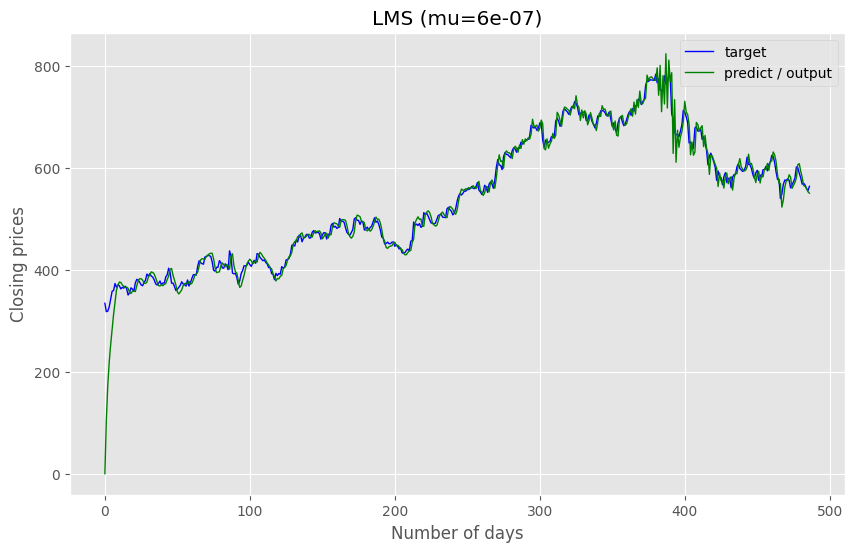

In [ ]:
#%matplotlib notebook
%matplotlib inline
plt.figure(figsize=(10, 6))
#plt.subplot(211)
plt.title(f'LMS (mu={mu_})')
plt.plot(d[: (len(d)-n)], 'b', label='target',linewidth='1')
plt.plot(y_lms[: (len(y_lms)-n)], 'g', label='predict / output',linewidth='1')
plt.xlabel('Number of days')
plt.ylabel('Closing prices')
plt.legend()
plt.show()

In [ ]:
_avg_error_lms = round(np.mean(10*np.log10(e_lms[: (len(e_lms) - n)]**2)), 2)
_avg_error_lms

16.68

Text(0.5, 1.0, 'Filter error: Avg error:16.68')

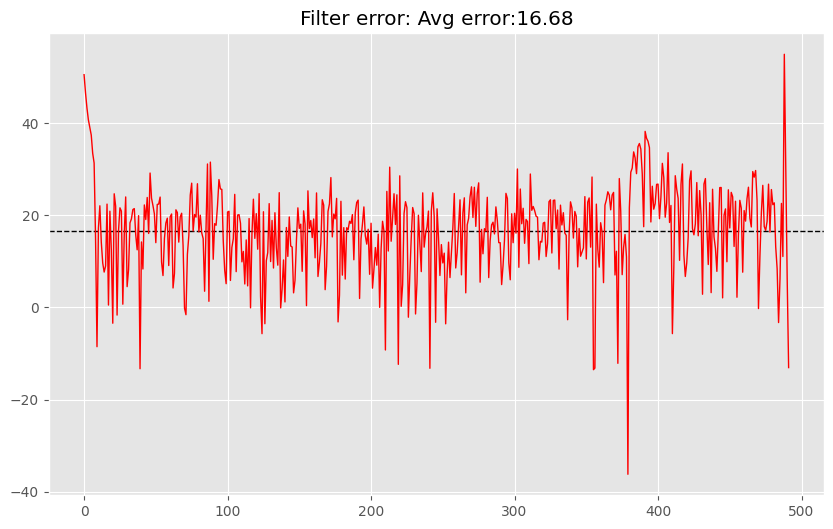

In [ ]:
plt.figure(figsize=(10,6))
plt.axhline(y=_avg_error_lms, color='black', lw=1, linestyle='--')
plt.plot(pa.misc.logSE(e_lms), "r", label="Squared error" , linewidth=1)
plt.title(f'Filter error: Avg error:{_avg_error_lms}')

In [ ]:
mse_lms = pa.misc.MSE(e_lms)
rmse_lms = pa.misc.RMSE(e_lms)
mse_lms

1250.4560713408262

In [ ]:
rmse_lms

35.36178829387487

## Realtime Prediction

In [ ]:
s_future=np.array(df['Close'])
s_future=s_future[split_index:]
x_future = pa.input_from_history(s_future,n)
d_future = np.zeros(len(x_future))
N_future = len(x_future)

for i,k in enumerate(range((n-1),N_future)):
    d_future[i] = s_future[k+1]
actual_list_lms = np.zeros(N_future)
pred_list_lms = np.zeros(N_future)

In [ ]:
for k in range(N_future):
    x_input = x_future[k]
    y_lms = f_lms.predict(x_input)
    d_actual = d_future[k]
    f_lms.adapt(d_actual,x_input)
    actual_list_lms[k] = d_actual
    pred_list_lms[k] = y_lms

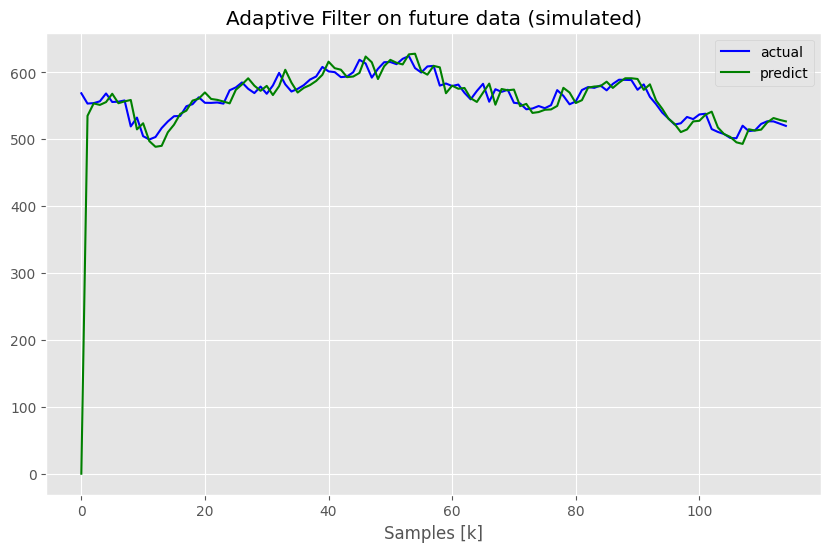

In [ ]:
plt.figure(figsize=(10,6))
#plt.subplot(211)
plt.title("Adaptive Filter on future data (simulated)")
plt.xlabel("Samples [k]")
plt.plot(actual_list_lms[: (len(actual_list_lms)-n)], "b", label="actual")
plt.plot(pred_list_lms[: (len(pred_list_lms)-n)], "g", label="predict")
plt.legend()

# NLMS filter with similar specifications

In [ ]:
mu_=1
f_nlms=pa.filters.FilterNLMS(n=5,mu=mu_,w='zeros')
y_nlms,e_nlms,w_nlms=f_nlms.run(d,x)
y_nlms

array([ 0.00000000e+00,  3.38794607e+02,  3.18304976e+02,  3.17850025e+02,
        3.27240312e+02,  3.44935726e+02,  3.63083877e+02,  3.68182924e+02,
        3.84678408e+02,  3.73426358e+02,  3.75909048e+02,  3.70558132e+02,
        3.62841513e+02,  3.63809483e+02,  3.63431018e+02,  3.67179541e+02,
        3.61797751e+02,  3.47899499e+02,  3.52655962e+02,  3.64529781e+02,
        3.60834211e+02,  3.56550621e+02,  3.79028754e+02,  3.86447399e+02,
        3.82736267e+02,  3.78121887e+02,  3.72498711e+02,  3.67363478e+02,
        3.73628867e+02,  3.79207316e+02,  3.94786708e+02,  3.90697280e+02,
        3.97183138e+02,  3.89919221e+02,  3.86639783e+02,  3.77922636e+02,
        3.69492708e+02,  3.65511329e+02,  3.70311634e+02,  3.76344970e+02,
        3.68547126e+02,  3.74075110e+02,  3.74448590e+02,  3.88552813e+02,
        3.92535155e+02,  4.09865948e+02,  3.98687411e+02,  3.73412438e+02,
        3.71322452e+02,  3.62487564e+02,  3.50861415e+02,  3.55224549e+02,
        3.63873892e+02,  

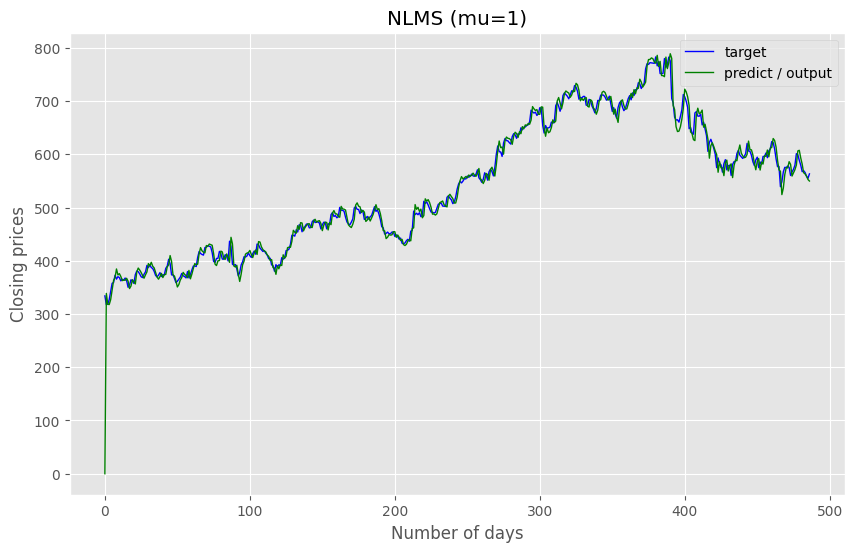

In [ ]:
#%matplotlib notebook
%matplotlib inline
plt.figure(figsize=(10, 6))
#plt.subplot(211)
plt.title(f'NLMS (mu={mu_})')
plt.plot(d[: (len(d)-n)], 'b', label='target',linewidth='1')
plt.plot(y_nlms[: (len(y_nlms)-n)], 'g', label='predict / output',linewidth='1')
plt.xlabel('Number of days')
plt.ylabel('Closing prices')
plt.legend()
plt.show()

In [ ]:
_avg_error_nlms = round(np.mean(10*np.log10(e_nlms[: (len(e_nlms) - n)]**2)), 2)
_avg_error_nlms

15.63

Text(0.5, 1.0, 'Filter error: Avg error:15.63')

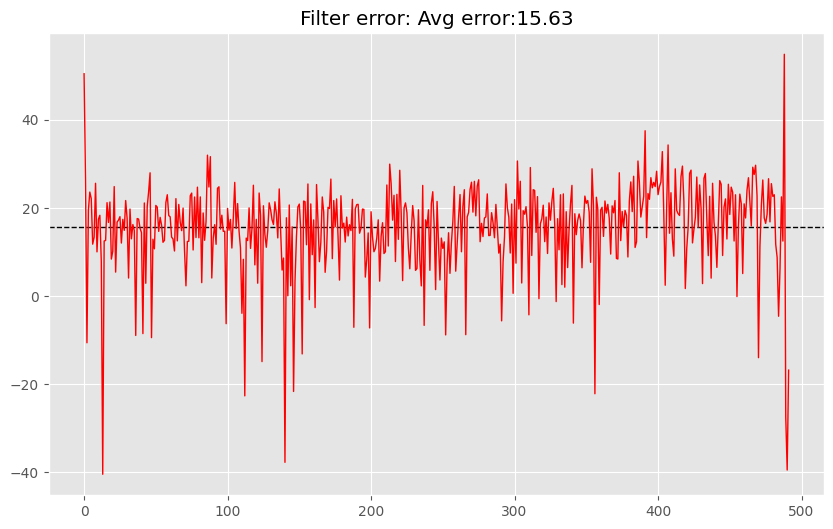

In [ ]:
plt.figure(figsize=(10,6))
plt.axhline(y=_avg_error_nlms, color='black', lw=1, linestyle='--')
plt.plot(pa.misc.logSE(e_nlms), "r", label="Squared error" , linewidth=1)
plt.title(f'Filter error: Avg error:{_avg_error_nlms}')

In [ ]:
mse_nlms = pa.misc.MSE(e_nlms)
rmse_nlms = pa.misc.RMSE(e_nlms)
mse_nlms

996.8617428124313

In [ ]:
rmse_nlms

31.57311740725694

## Realtime prediction loop - nlms

In [ ]:
actual_list_nlms = np.zeros(N_future)
pred_list_nlms = np.zeros(N_future)

for k in range(N_future):
    x_input = x_future[k]
    y_nlms = f_nlms.predict(x_input)
    d_actual = d_future[k]
    f_nlms.adapt(d_actual,x_input)
    actual_list_nlms[k] = d_actual
    pred_list_nlms[k] = y_nlms

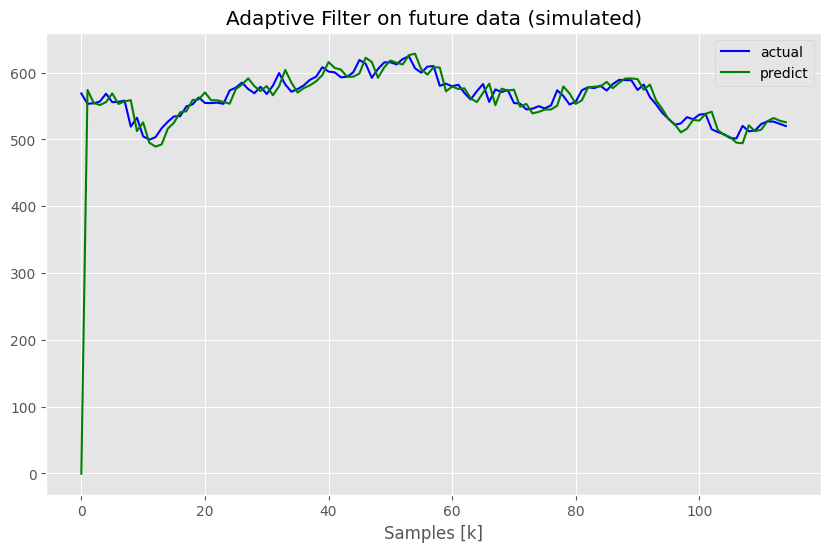

In [ ]:
plt.figure(figsize=(10,6))
#plt.subplot(211)
plt.title("Adaptive Filter on future data (simulated)")
plt.xlabel("Samples [k]")
plt.plot(actual_list_nlms[: (len(actual_list_nlms)-n)], "b", label="actual")
plt.plot(pred_list_nlms[: (len(pred_list_nlms)-n)], "g", label="predict")
plt.legend()

# RLS filter with similar specifications

In [ ]:
#ro is the max limit of the step size
mu_=1.01
f_rls=pa.filters.FilterRLS(n=5,mu=mu_,w='zeros')
y_rls,e_rls,w_rls=f_rls.run(d,x)
y_rls

array([  0.        , 338.79461242, 292.65993916, 304.91319041,
       340.75463707, 409.3447513 , 345.3914717 , 345.00063415,
       367.6644038 , 365.24290064, 371.56102389, 373.44279127,
       373.02229707, 367.95366111, 372.05086264, 374.31633418,
       366.33804963, 349.97828749, 354.54869409, 373.22662956,
       368.24679836, 356.78200327, 375.89717853, 383.64865822,
       381.26089881, 374.70578298, 371.26046379, 371.5807256 ,
       379.25693659, 382.42402083, 394.71128844, 386.45077135,
       393.30458147, 387.84875778, 388.23813947, 381.87866694,
       374.71417694, 372.22423237, 376.99492224, 381.58584542,
       370.84255601, 374.68559354, 375.22777405, 389.0411051 ,
       391.57407218, 404.28661581, 393.98646701, 369.5870599 ,
       375.59870249, 372.62544254, 362.53907455, 363.44907004,
       368.71559609, 371.77639352, 377.47928992, 371.23709724,
       369.93563226, 367.70468234, 383.2794726 , 368.28759642,
       374.62495761, 383.84605673, 392.9099994 , 389.70

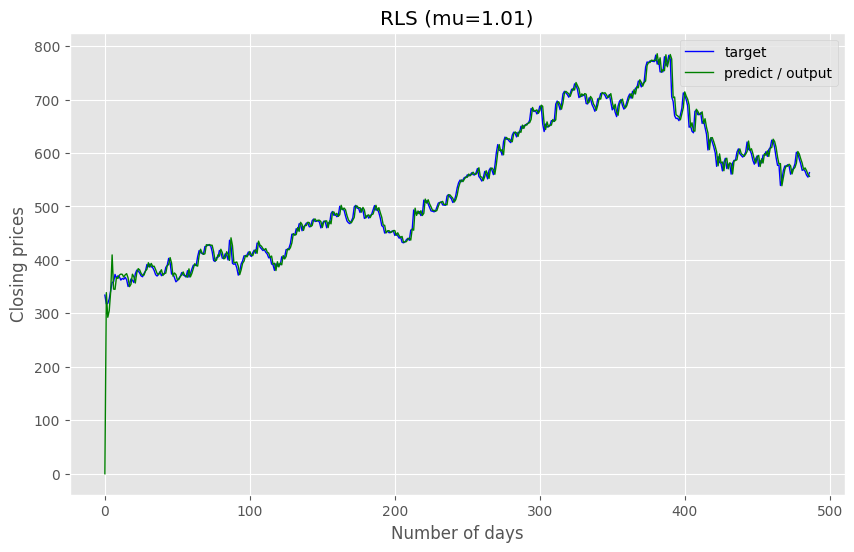

In [ ]:
#%matplotlib notebook
%matplotlib inline
plt.figure(figsize=(10, 6))
#plt.subplot(211)
plt.title(f'RLS (mu={mu_})')
plt.plot(d[: (len(d)-n)], 'b', label='target',linewidth='1')
plt.plot(y_rls[: (len(y_rls)-n)], 'g', label='predict / output',linewidth='1')
plt.xlabel('Number of days')
plt.ylabel('Closing prices')
plt.legend()
plt.show()

In [ ]:
avg_error_rls = round(np.mean(10*np.log10(e_rls[: (len(e_rls) - n)]**2)), 2)
avg_error_rls

13.72

Text(0.5, 1.0, 'Filter error: Avg error:13.72')

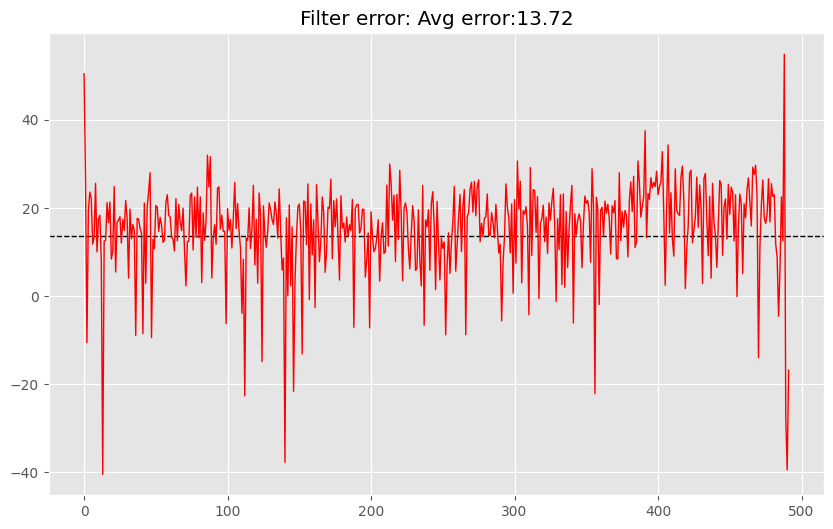

In [ ]:
plt.figure(figsize=(10,6))
plt.axhline(y=avg_error_rls, color='black', lw=1, linestyle='--')
plt.plot(pa.misc.logSE(e_nlms), "r", label="Squared error" , linewidth=1)
plt.title(f'Filter error: Avg error:{avg_error_rls}')

In [ ]:
mse_rls = pa.misc.MSE(e_rls)
rmse_rls = pa.misc.RMSE(e_rls)
mse_rls

2878.072984538377

In [ ]:
rmse_rls

53.64767454921394